### Deep learning model training.


In [1]:
import time
import torch
import random
import torch.nn as nn
from glob import glob
from notebooks import config
from torchinfo import summary
from utils.imgShow import imsShow
from utils.utils import read_scenes
from utils.metrics import oa_binary, miou_binary
from utils.dataloader import SceneArraySet, PatchPathSet
from model import u2net


In [2]:
patch_size = 512  ## patch size setting
# ## traset
paths_scene_tra, paths_dem_tra, paths_truth_tra = config.paths_scene_tra, config.paths_dem_tra, config.paths_truth_tra
print(f'train scenes: {len(paths_scene_tra)}')
## valset
paths_patch_valset = sorted(glob('data/dset/valset/patch_'+str(patch_size)+'/*'))
print(f'vali patch: {len(paths_patch_valset)}')


train scenes: 48
vali patch: 275


### dataset loading

In [3]:
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra) 


In [4]:
## Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         path_size=(patch_size, patch_size))
val_data = PatchPathSet(paths_valset=paths_patch_valset)
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4)


#### Model training

In [5]:
### check model
model = u2net(num_bands_b1=6, num_bands_b2=1)
summary(model, input_size=(1,7,256,256), device='cpu')


Layer (type:depth-idx)                   Output Shape              Param #
u2net                                    [1, 1, 256, 256]          --
├─Sequential: 1-1                        [1, 16, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 16, 256, 256]         880
│    └─BatchNorm2d: 2-2                  [1, 16, 256, 256]         32
│    └─ReLU: 2-3                         [1, 16, 256, 256]         --
├─Sequential: 1-2                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-4                       [1, 32, 128, 128]         4,640
│    └─BatchNorm2d: 2-5                  [1, 32, 128, 128]         64
│    └─ReLU: 2-6                         [1, 32, 128, 128]         --
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-7                       [1, 64, 64, 64]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 64, 64]           128
│    └─ReLU: 2-9                         [1, 64, 64, 64]           --
├─Sequ

In [6]:
### create loss and optimizer
loss_bce = nn.BCELoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                                          mode='min', factor=0.6, patience=20)

In [7]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x.float())
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, 
                    tra_loader, val_loader, epoches, 
                    device, lr_scheduler=None):
    tra_loss_loops, tra_miou_loops, tra_oa_loops = [], [], []
    val_loss_loops, val_miou_loops, val_oa_loops = [], [], []
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        if lr_scheduler:
          lr_scheduler.step(tra_loss)    # if using ReduceLROnPlateau
        '''-----validation the model-----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou), tra_oa_loops.append(tra_oa)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou), val_oa_loops.append(val_oa)
        print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.2f},Miou:{tra_miou:.2f}, '
            f'val-> Loss:{val_loss:.2f},Oa:{val_oa:.2f},Miou:{val_miou:.2f},time:{time.time()-start:.0f}s')
        ## show the result
        if (epoch+1)%20 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch.float(), 0).to(device), truth.to(device)
            pred = model(patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pdem = patch[:,:, -1]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            imsShow([patch, pdem, truth, pred], 
                    clip_list = (2,2,0,0),
                    img_name_list=['input_patch', 'pdem', 'truth', 'prediction'], 
                    
                    figsize=(13,3))
    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'tra_oa': tra_oa_loops, 
                'val_loss': val_loss_loops, 'val_miou': val_miou_loops, 'val_oa': val_oa_loops}
    return metrics 


Ep1: tra-> Loss:0.447,Oa:0.87,Miou:0.80, val-> Loss:0.58,Oa:0.82,Miou:0.53,time:4s
Ep2: tra-> Loss:0.314,Oa:0.89,Miou:0.71, val-> Loss:0.29,Oa:0.87,Miou:0.76,time:4s
Ep3: tra-> Loss:0.167,Oa:0.90,Miou:0.85, val-> Loss:0.21,Oa:0.90,Miou:0.79,time:5s
Ep4: tra-> Loss:0.143,Oa:0.92,Miou:0.86, val-> Loss:0.22,Oa:0.91,Miou:0.80,time:4s
Ep5: tra-> Loss:0.099,Oa:0.93,Miou:0.84, val-> Loss:0.18,Oa:0.90,Miou:0.81,time:4s
Ep6: tra-> Loss:0.122,Oa:0.91,Miou:0.86, val-> Loss:0.18,Oa:0.92,Miou:0.81,time:4s
Ep7: tra-> Loss:0.106,Oa:0.92,Miou:0.87, val-> Loss:0.16,Oa:0.91,Miou:0.83,time:4s
Ep8: tra-> Loss:0.143,Oa:0.92,Miou:0.86, val-> Loss:0.18,Oa:0.92,Miou:0.82,time:4s
Ep9: tra-> Loss:0.089,Oa:0.96,Miou:0.92, val-> Loss:0.15,Oa:0.92,Miou:0.83,time:4s
Ep10: tra-> Loss:0.108,Oa:0.95,Miou:0.90, val-> Loss:0.16,Oa:0.92,Miou:0.83,time:4s
Ep11: tra-> Loss:0.110,Oa:0.91,Miou:0.87, val-> Loss:0.14,Oa:0.92,Miou:0.84,time:4s
Ep12: tra-> Loss:0.073,Oa:0.91,Miou:0.87, val-> Loss:0.14,Oa:0.93,Miou:0.84,time:4s
E

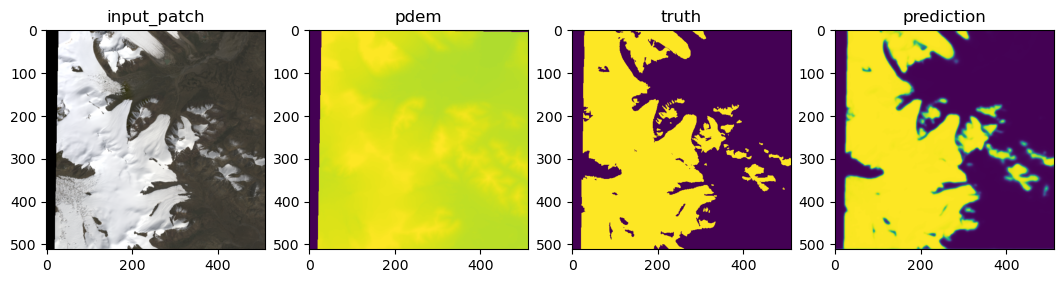

Ep21: tra-> Loss:0.055,Oa:0.95,Miou:0.92, val-> Loss:0.09,Oa:0.95,Miou:0.89,time:4s
Ep22: tra-> Loss:0.070,Oa:0.96,Miou:0.93, val-> Loss:0.08,Oa:0.96,Miou:0.89,time:5s
Ep23: tra-> Loss:0.074,Oa:0.96,Miou:0.92, val-> Loss:0.08,Oa:0.96,Miou:0.89,time:4s
Ep24: tra-> Loss:0.060,Oa:0.96,Miou:0.92, val-> Loss:0.09,Oa:0.94,Miou:0.88,time:4s
Ep25: tra-> Loss:0.091,Oa:0.92,Miou:0.88, val-> Loss:0.08,Oa:0.95,Miou:0.90,time:5s
Ep26: tra-> Loss:0.073,Oa:0.93,Miou:0.90, val-> Loss:0.12,Oa:0.93,Miou:0.85,time:4s
Ep27: tra-> Loss:0.062,Oa:0.97,Miou:0.93, val-> Loss:0.10,Oa:0.94,Miou:0.86,time:4s
Ep28: tra-> Loss:0.057,Oa:0.96,Miou:0.93, val-> Loss:0.09,Oa:0.94,Miou:0.87,time:4s
Ep29: tra-> Loss:0.089,Oa:0.94,Miou:0.88, val-> Loss:0.08,Oa:0.96,Miou:0.90,time:4s
Ep30: tra-> Loss:0.056,Oa:0.95,Miou:0.92, val-> Loss:0.07,Oa:0.96,Miou:0.91,time:4s
Ep31: tra-> Loss:0.055,Oa:0.97,Miou:0.92, val-> Loss:0.07,Oa:0.96,Miou:0.91,time:4s
Ep32: tra-> Loss:0.065,Oa:0.94,Miou:0.89, val-> Loss:0.07,Oa:0.96,Miou:0.91,

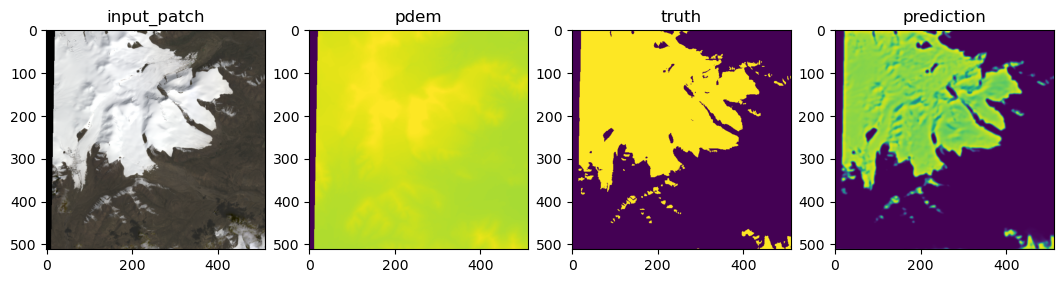

Ep41: tra-> Loss:0.052,Oa:0.97,Miou:0.93, val-> Loss:0.08,Oa:0.95,Miou:0.91,time:5s
Ep42: tra-> Loss:0.078,Oa:0.96,Miou:0.91, val-> Loss:0.09,Oa:0.96,Miou:0.88,time:4s
Ep43: tra-> Loss:0.054,Oa:0.97,Miou:0.89, val-> Loss:0.08,Oa:0.96,Miou:0.90,time:4s
Ep44: tra-> Loss:0.061,Oa:0.94,Miou:0.91, val-> Loss:0.07,Oa:0.97,Miou:0.91,time:5s
Ep45: tra-> Loss:0.066,Oa:0.97,Miou:0.92, val-> Loss:0.07,Oa:0.96,Miou:0.91,time:4s
Ep46: tra-> Loss:0.054,Oa:0.94,Miou:0.89, val-> Loss:0.07,Oa:0.96,Miou:0.91,time:4s
Ep47: tra-> Loss:0.055,Oa:0.93,Miou:0.90, val-> Loss:0.07,Oa:0.97,Miou:0.92,time:4s
Ep48: tra-> Loss:0.049,Oa:0.93,Miou:0.90, val-> Loss:0.07,Oa:0.97,Miou:0.92,time:4s
Ep49: tra-> Loss:0.033,Oa:0.94,Miou:0.91, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:5s
Ep50: tra-> Loss:0.056,Oa:0.96,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.92,time:4s
Ep51: tra-> Loss:0.043,Oa:0.98,Miou:0.95, val-> Loss:0.07,Oa:0.96,Miou:0.92,time:4s
Ep52: tra-> Loss:0.042,Oa:0.96,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.92,

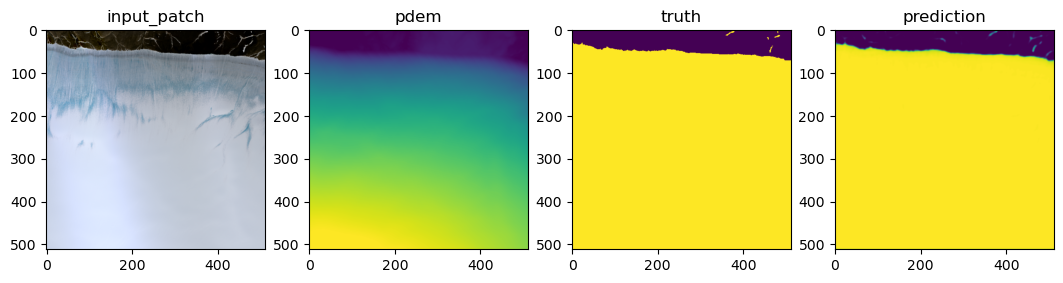

Ep61: tra-> Loss:0.038,Oa:0.97,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep62: tra-> Loss:0.036,Oa:0.94,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep63: tra-> Loss:0.036,Oa:0.97,Miou:0.96, val-> Loss:0.07,Oa:0.97,Miou:0.92,time:4s
Ep64: tra-> Loss:0.038,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep65: tra-> Loss:0.036,Oa:0.97,Miou:0.95, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep66: tra-> Loss:0.055,Oa:0.97,Miou:0.94, val-> Loss:0.07,Oa:0.96,Miou:0.91,time:4s
Ep67: tra-> Loss:0.051,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep68: tra-> Loss:0.050,Oa:0.94,Miou:0.91, val-> Loss:0.06,Oa:0.97,Miou:0.94,time:5s
Ep69: tra-> Loss:0.051,Oa:0.94,Miou:0.92, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep70: tra-> Loss:0.046,Oa:0.98,Miou:0.95, val-> Loss:0.06,Oa:0.97,Miou:0.92,time:4s
Ep71: tra-> Loss:0.029,Oa:0.97,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:5s
Ep72: tra-> Loss:0.037,Oa:0.97,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.93,

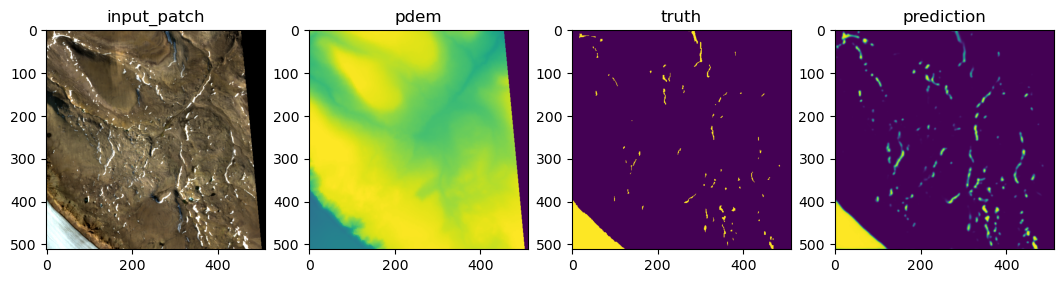

Ep81: tra-> Loss:0.042,Oa:0.97,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep82: tra-> Loss:0.034,Oa:0.96,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep83: tra-> Loss:0.037,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep84: tra-> Loss:0.032,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep85: tra-> Loss:0.037,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep86: tra-> Loss:0.035,Oa:0.97,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep87: tra-> Loss:0.031,Oa:0.97,Miou:0.95, val-> Loss:0.06,Oa:0.97,Miou:0.92,time:4s
Ep88: tra-> Loss:0.044,Oa:0.97,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.94,time:4s
Ep89: tra-> Loss:0.048,Oa:0.96,Miou:0.90, val-> Loss:0.11,Oa:0.96,Miou:0.90,time:4s
Ep90: tra-> Loss:0.052,Oa:0.96,Miou:0.92, val-> Loss:0.07,Oa:0.96,Miou:0.91,time:4s
Ep91: tra-> Loss:0.042,Oa:0.96,Miou:0.90, val-> Loss:0.06,Oa:0.97,Miou:0.92,time:4s
Ep92: tra-> Loss:0.045,Oa:0.96,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.92,

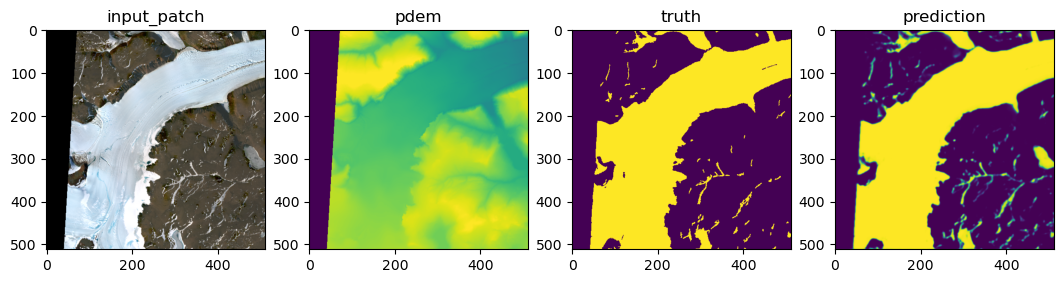

Ep101: tra-> Loss:0.035,Oa:0.97,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep102: tra-> Loss:0.036,Oa:0.98,Miou:0.96, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep103: tra-> Loss:0.050,Oa:0.97,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.92,time:5s
Ep104: tra-> Loss:0.038,Oa:0.97,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.92,time:4s
Ep105: tra-> Loss:0.043,Oa:0.97,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:5s
Ep106: tra-> Loss:0.037,Oa:0.97,Miou:0.95, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep107: tra-> Loss:0.039,Oa:0.96,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep108: tra-> Loss:0.046,Oa:0.96,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:5s
Ep109: tra-> Loss:0.055,Oa:0.97,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep110: tra-> Loss:0.037,Oa:0.95,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.94,time:4s
Ep111: tra-> Loss:0.043,Oa:0.97,Miou:0.94, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep112: tra-> Loss:0.045,Oa:0.97,Miou:0.93, val-> Loss:0.06,Oa:0.9

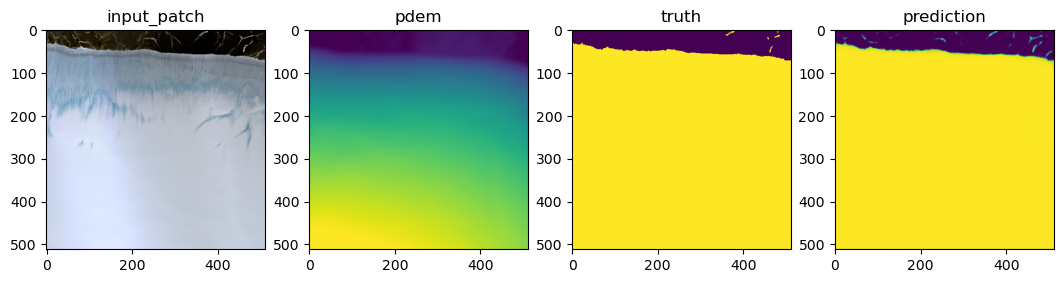

Ep121: tra-> Loss:0.041,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep122: tra-> Loss:0.026,Oa:0.99,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep123: tra-> Loss:0.034,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep124: tra-> Loss:0.036,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep125: tra-> Loss:0.039,Oa:0.97,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep126: tra-> Loss:0.036,Oa:0.97,Miou:0.95, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep127: tra-> Loss:0.032,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep128: tra-> Loss:0.032,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep129: tra-> Loss:0.036,Oa:0.97,Miou:0.93, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep130: tra-> Loss:0.038,Oa:0.97,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep131: tra-> Loss:0.035,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep132: tra-> Loss:0.032,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.9

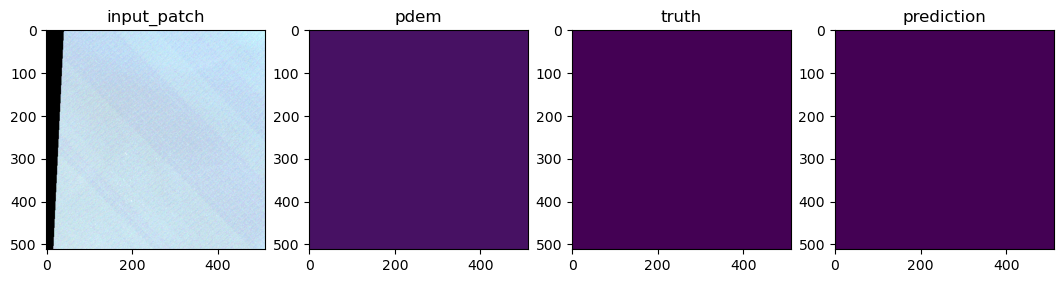

Ep141: tra-> Loss:0.033,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep142: tra-> Loss:0.037,Oa:0.94,Miou:0.93, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep143: tra-> Loss:0.038,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep144: tra-> Loss:0.034,Oa:0.97,Miou:0.94, val-> Loss:0.08,Oa:0.94,Miou:0.89,time:4s
Ep145: tra-> Loss:0.060,Oa:0.95,Miou:0.92, val-> Loss:0.08,Oa:0.97,Miou:0.92,time:5s
Ep146: tra-> Loss:0.030,Oa:0.98,Miou:0.94, val-> Loss:0.10,Oa:0.97,Miou:0.92,time:4s
Ep147: tra-> Loss:0.031,Oa:0.95,Miou:0.92, val-> Loss:0.09,Oa:0.97,Miou:0.92,time:4s
Ep148: tra-> Loss:0.053,Oa:0.97,Miou:0.94, val-> Loss:0.07,Oa:0.97,Miou:0.92,time:4s
Ep149: tra-> Loss:0.038,Oa:0.98,Miou:0.96, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep150: tra-> Loss:0.038,Oa:0.98,Miou:0.93, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep151: tra-> Loss:0.034,Oa:0.94,Miou:0.91, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep152: tra-> Loss:0.037,Oa:0.96,Miou:0.92, val-> Loss:0.06,Oa:0.9

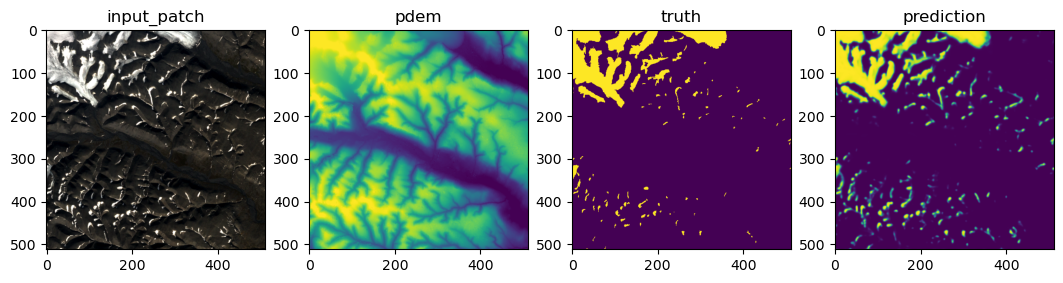

Ep161: tra-> Loss:0.048,Oa:0.95,Miou:0.92, val-> Loss:0.06,Oa:0.97,Miou:0.93,time:4s
Ep162: tra-> Loss:0.037,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep163: tra-> Loss:0.032,Oa:0.97,Miou:0.93, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep164: tra-> Loss:0.034,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep165: tra-> Loss:0.025,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep166: tra-> Loss:0.038,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep167: tra-> Loss:0.038,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep168: tra-> Loss:0.039,Oa:0.97,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep169: tra-> Loss:0.041,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep170: tra-> Loss:0.033,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep171: tra-> Loss:0.034,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep172: tra-> Loss:0.042,Oa:0.97,Miou:0.94, val-> Loss:0.05,Oa:0.9

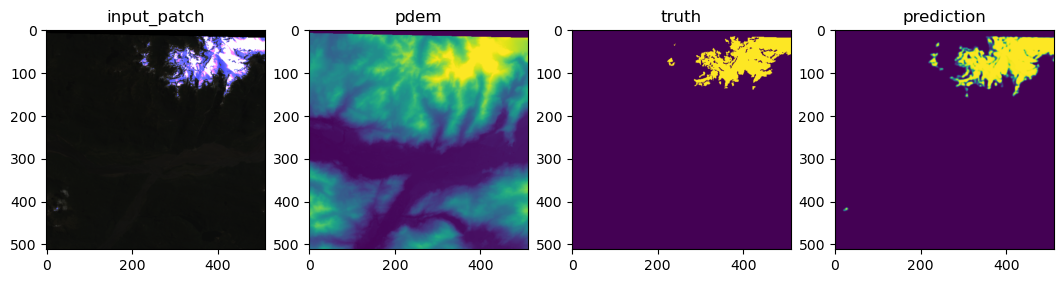

Ep181: tra-> Loss:0.036,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep182: tra-> Loss:0.029,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep183: tra-> Loss:0.041,Oa:0.97,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep184: tra-> Loss:0.045,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep185: tra-> Loss:0.031,Oa:0.96,Miou:0.94, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep186: tra-> Loss:0.041,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep187: tra-> Loss:0.032,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep188: tra-> Loss:0.030,Oa:0.98,Miou:0.96, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep189: tra-> Loss:0.034,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep190: tra-> Loss:0.032,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:4s
Ep191: tra-> Loss:0.030,Oa:0.97,Miou:0.95, val-> Loss:0.05,Oa:0.97,Miou:0.93,time:5s
Ep192: tra-> Loss:0.039,Oa:0.98,Miou:0.95, val-> Loss:0.05,Oa:0.9

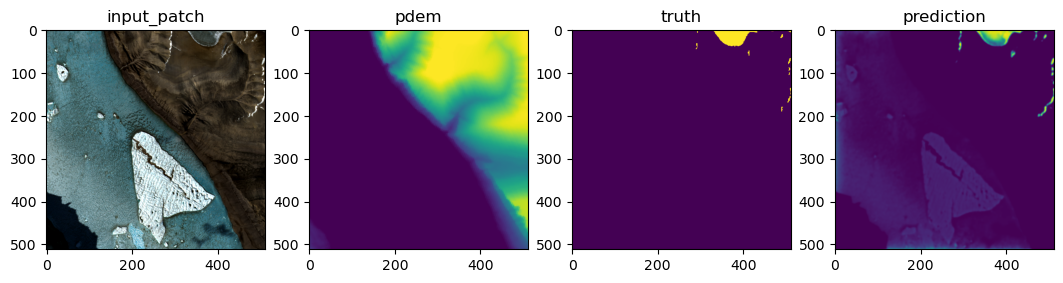

In [8]:
device = torch.device('cuda:0') 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metrics = train_loops(model=model, 
                epoches=200,  
                loss_fn=loss_bce,  
                optimizer=optimizer,  
                tra_loader=tra_loader,    
                val_loader=val_loader,  
                lr_scheduler=lr_scheduler,
                device=device)     


In [9]:
# ## model saving
# net_name = 'unet'
# # net_name = 'deeplabv3plus'
# net_name = 'deeplabv3plus_mobilev2'
# # net_name = 'hrnet'
# path_save = f'model/trained/{net_name}.pth'
# torch.save(model.state_dict(), path_save)   ## save weights of the trained model 
# model.load_state_dict(torch.load(path_save, weights_only=True))  # load the weights of the trained model
# ## metrics saving
# path_metrics = f'model/trained/{net_name}_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')

